In [1]:
import torch
import os
import json
import tqdm
import collections
import random
import matplotlib.pyplot as plt
import numpy as np
import scipy

import utils
import som

In [2]:
fnames = os.listdir("data")
fields = ['name','smiles','notes']
molecules = []
for fname in tqdm.tqdm(fnames):
    with open(os.path.join("data",fname)) as f:
        mol = json.load(f)
        data = {k:mol[k] for k in fields}
        # Check that the molecule has all the fields of interest
        if all(data.values()):
            molecules.append(data)

# Have to de-dupe the notes for each molecule.
for mol in molecules:
    mol["notes"] = set(mol["notes"])
    
print(f"Found {len(molecules)} molecules.")
molecules[:3]

100%|███████████████████████████████████| 19194/19194 [00:02<00:00, 6723.17it/s]

Found 3440 molecules.


[{'name': 'amyl butyrate',
  'smiles': 'CCCCCOC(=O)CCC',
  'notes': {'banana', 'cherry', 'fruity', 'pineapple', 'sweet', 'tropical'}},
 {'name': 'para-anisyl phenyl acetate',
  'smiles': 'COC1=CC=C(C=C1)COC(=O)CC2=CC=CC=C2',
  'notes': {'anise', 'balsamic', 'honey', 'woody'}},
 {'name': 'dihydrofarnesol',
  'smiles': 'CC(CC/C=C(\\C)/CCC=C(C)C)CCO',
  'notes': {'cyclamen', 'floral', 'metallic'}}]

In [3]:
all_notes = collections.Counter()
for mol in molecules:
    all_notes.update(mol["notes"])
print(f"Found {len(all_notes)} unique notes.")
print("Most common:")
print(all_notes.most_common(5))

Found 502 unique notes.
Most common:
[('fruity', 1060), ('green', 967), ('sweet', 884), ('floral', 706), ('woody', 558)]


In [4]:
all_notes_list = list(all_notes.keys())

def multi_hot(notes):
    indices = torch.tensor([all_notes_list.index(n) for n in notes])
    if len(indices) == 0:
        # Occurs when the notes in the pair were removed due to infrequency.
        raise AttributeError("Found no valid notes.")
    one_hots = torch.nn.functional.one_hot(indices, len(all_notes))
    return one_hots.sum(dim=0).float()

for mol in molecules:
    mol["encoding"] = multi_hot(mol["notes"])

print(molecules[0])

{'name': 'amyl butyrate', 'smiles': 'CCCCCOC(=O)CCC', 'notes': {'cherry', 'banana', 'fruity', 'pineapple', 'tropical', 'sweet'}, 'encoding': tensor([1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [117]:
def do_train(config,verbose=False):
    shape = (config["width"], config["height"], len(all_notes_list))
    map = som.SOM(shape=shape,
              wrapping=som.WrappingMode.SPHERICAL,
              gauss=config["gauss"],
              decay=config["decay"],
              use_onehot=config["onehot"])

    encodings = torch.stack([mol["encoding"] for mol in molecules])

    steps = int(config["width"] * config["height"])
    for i in tqdm.tqdm(range(steps),smoothing=0, disable=not verbose):
        map.update_batch(encodings)
        map.do_decay()

    return map

mapw = 5
maph = 4

# In general, the larger the initial gauss, the longer the training will have to be
# Though using a stronger decay reduces this.
# A larger initial gauss does tend to lead to better distributions, though.

map = do_train({'width': mapw, 'height': maph, "gauss":min(mapw,maph)/2, "decay": .9, "onehot": True},verbose=True)
note_encodings = torch.stack([multi_hot([n]) for n,f in all_notes.most_common()])
all_activations = torch.stack([map.get_activations(enc) for enc in note_encodings])
amin, amax = all_activations.min(), all_activations.max()

100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 11.36it/s]


fruity w/ (0.00,1.00)
(401, 301)


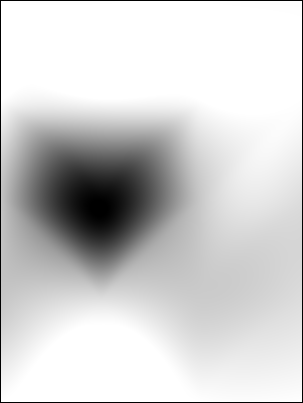

green w/ (0.00,0.56)
(401, 301)


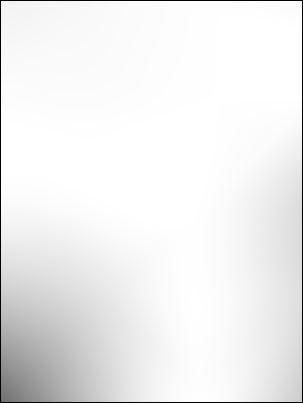

sweet w/ (0.00,0.55)
(401, 301)


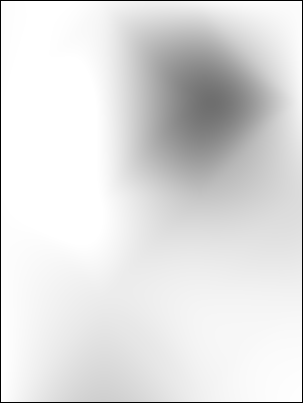

floral w/ (0.00,0.44)
(401, 301)


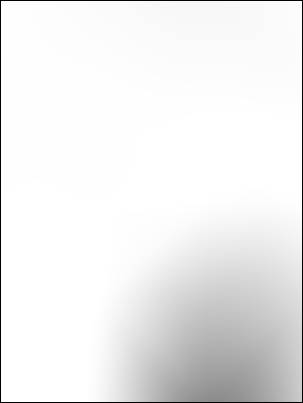

woody w/ (0.00,0.51)
(401, 301)


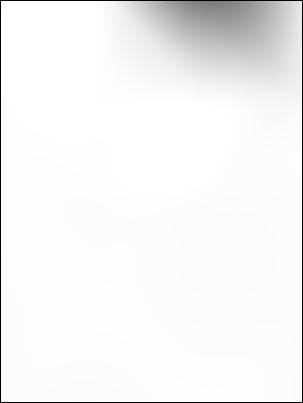

herbal w/ (0.00,0.25)
(401, 301)


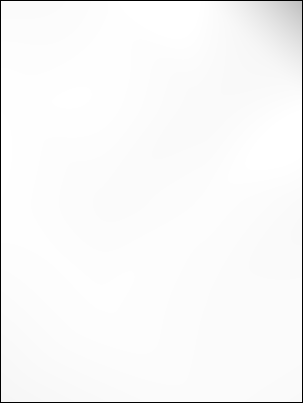

fresh w/ (0.00,0.08)
(401, 301)


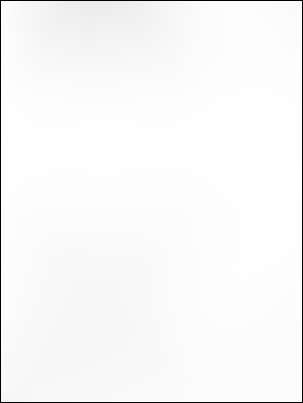

fatty w/ (0.00,0.20)
(401, 301)


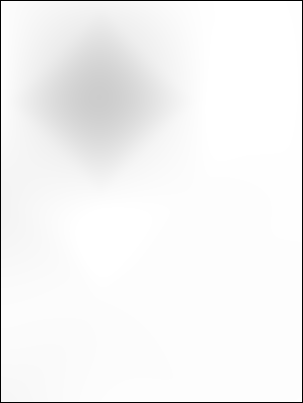

waxy w/ (0.00,0.13)
(401, 301)


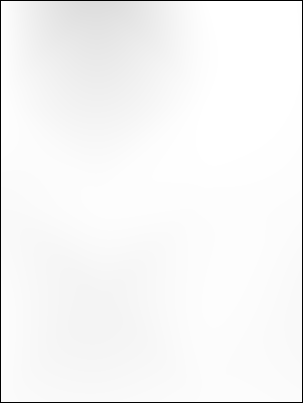

spicy w/ (0.00,0.12)
(401, 301)


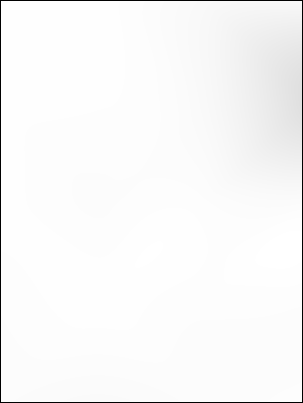

In [179]:
import PIL

rsz = 15

def interpolate(activations, step):
    fine_grid = utils.get_idx_grid(map.width, map.height, step)
    fine_act = scipy.interpolate.griddata(map.map_idx.numpy(),
                                          activations.numpy(),
                                          fine_grid.numpy(),
                                          method="cubic")
    return fine_grid, torch.FloatTensor(fine_act)

def normalize(actvn,thresh=0):
    norm = (actvn - amin) / (amax - amin)
    norm = torch.clamp(norm,0,1)
    return torch.nn.functional.threshold(norm,thresh,0)

def to_img_array(actvn,step,invert,thresh=0):
    rsz_grid, rsz_actvn = interpolate(actvn,step)
    # I have no idea how I got these equations.
    nw,nh = ((map.width-1)/step)+1,((map.height-1)/step)+1
    nshape = (int(nw),int(nh))
    mtrx = normalize(rsz_actvn,thresh).reshape(nshape).numpy()
    if invert:
        mtrx = 1-mtrx
    mtrx_norm = mtrx*255
    
    return mtrx_norm.astype('uint8')

def add_border(pil_img, border):
    width, height = pil_img.size
    new_width = width + 2*border
    new_height = height + 2*border
    result = PIL.Image.new(pil_img.mode, (new_width, new_height), 0)
    result.paste(pil_img, (border, border))
    return result

def make_bw_pil(img_array, border=0):
    w,h = img_array.shape
    print(img_array.shape)
    img = PIL.Image.fromarray(img_array,mode="L")
    return add_border(img,border)

def make_empty_img_array(invert):
    return to_img_array(torch.full((map.width,map.height),amax),invert)

for n,f in all_notes.most_common(10):
    activations = map.get_activations(multi_hot([n]))
    norm = normalize(activations)
    print(f"{n} w/ ({norm.min().numpy():.2f},{norm.max().numpy():.2f})")
    display(make_bw_pil(to_img_array(activations,step=.01,invert=True),1))


[2. 1.]
(401, 301)


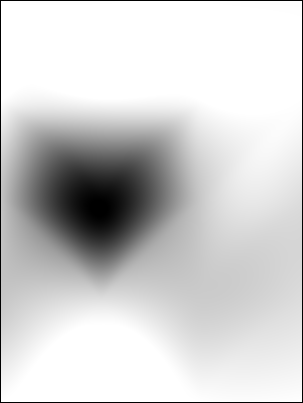

[4. 0.]
(401, 301)


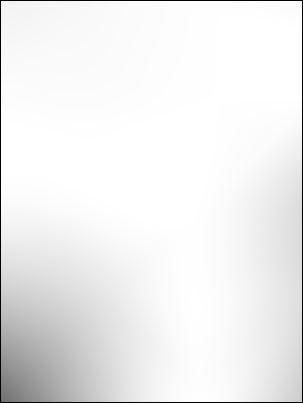

[1. 2.]
(401, 301)


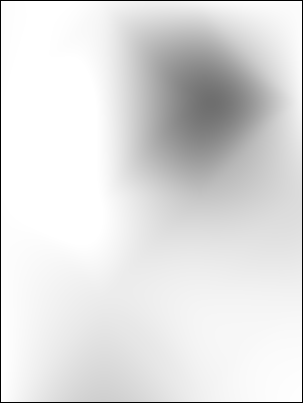

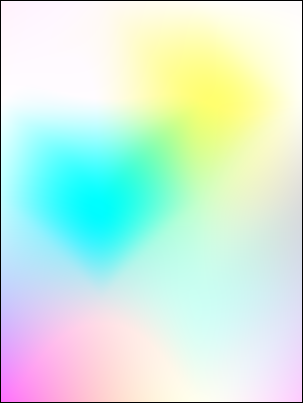

In [187]:
def make_rgb_pil(img_array,border=0):
    w,h,c = img_array.shape
    assert c == 3
    img = PIL.Image.fromarray(img_array,mode="RGB")
    return add_border(img,border)

all_imgs = []
for n,f in all_notes.most_common(3):
    activations = map.get_activations(multi_hot([n]))
    bmu = map.get_bmu(multi_hot([n]))
    print(map.map_idx[bmu].numpy().squeeze())
    imgar = to_img_array(activations,step=.01,invert=True,thresh=0)
    
    display(make_bw_pil(imgar,1))
    all_imgs.append(imgar)


# display(make_bw_pil(make_empty_img_array(False),30,1))
# all_imgs.append(make_empty_img_array(False))

rgb_img = np.stack(all_imgs,axis=-1)
display(make_rgb_pil(rgb_img,1))

(401, 301, 3)


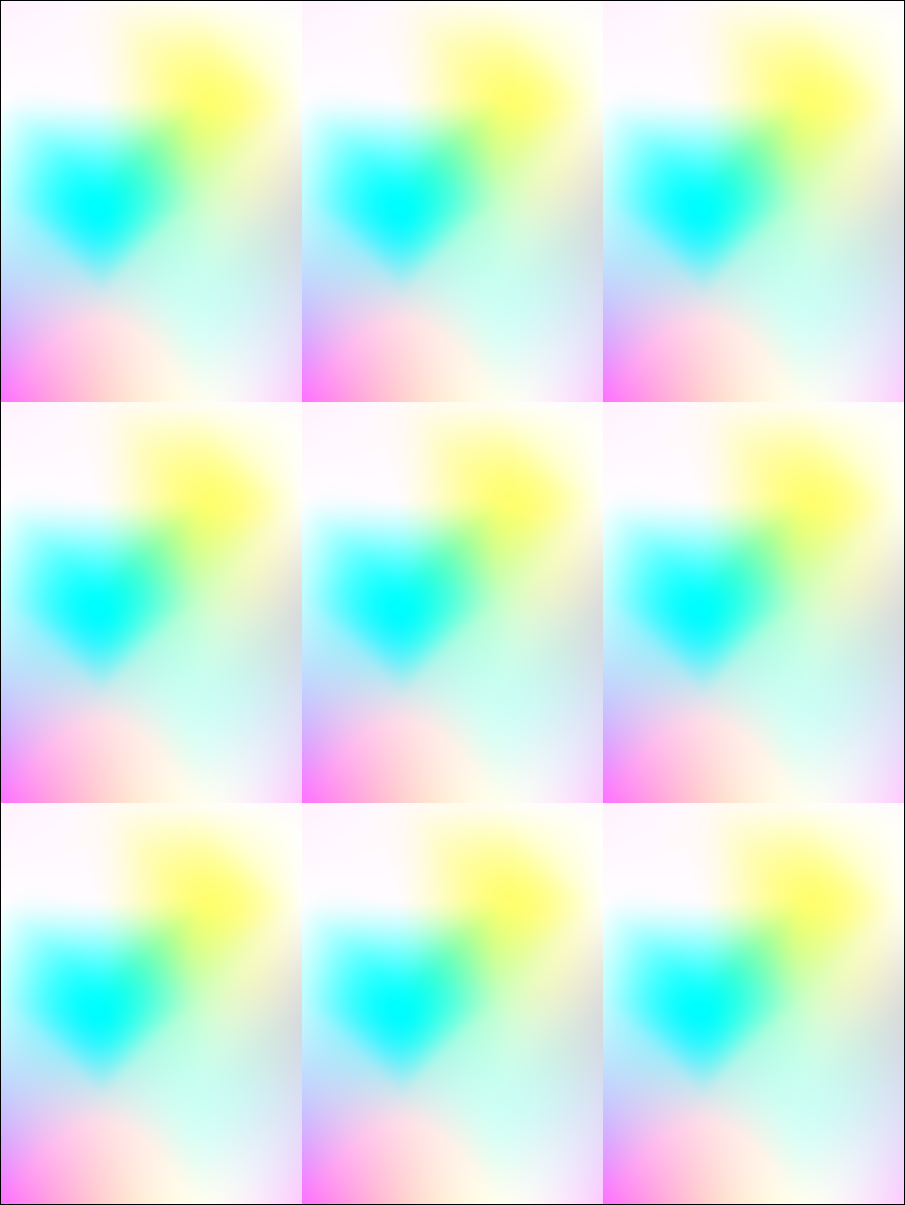

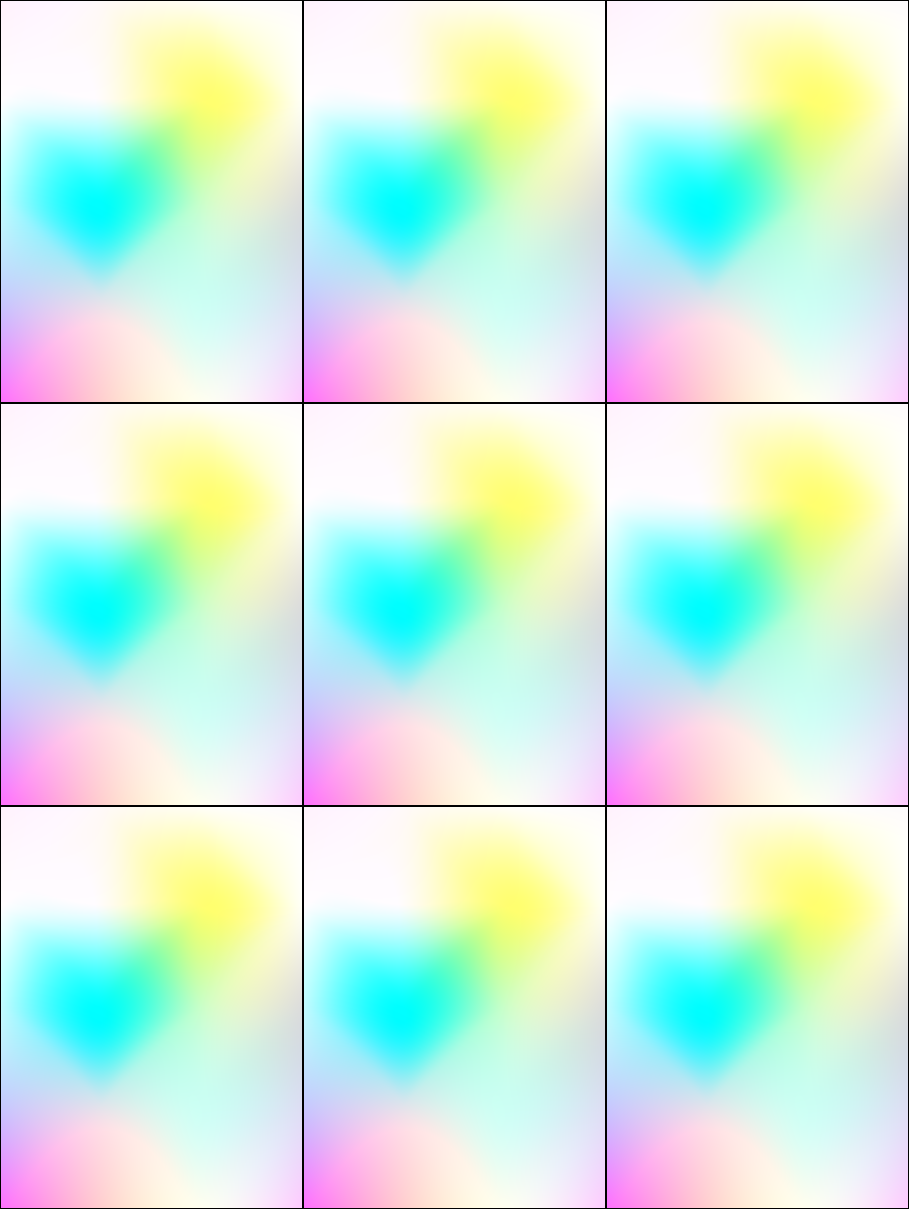

In [190]:
print(rgb_img.shape)
tiled = np.tile(rgb_img,(3,3,1))
display(make_rgb_pil(tiled,1))

# Attempting to tile the np arrays causes the border to be too thick.
def tile_pil(pil_img,tile_w,tile_h):
    w,h = pil_img.width, pil_img.height
    dst = PIL.Image.new(pil_img.mode, (w*tile_w, h*tile_h))
    for x in range(tile_w):
        for y in range(tile_h):
            dst.paste(pil_img,(x*w,y*h))
    return dst
    
display(tile_pil(make_rgb_pil(rgb_img,1),3,3))

tensor(100.) tensor(200.)
tensor(0.) tensor(400.)
tensor(200.) tensor(100.)


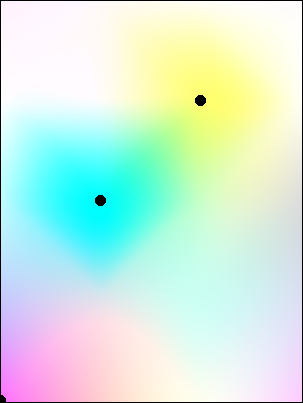

In [209]:
from PIL import ImageDraw

bmu_idxs = []
for n,f in all_notes.most_common(3):
    bmu_idxs.append(map.get_bmu_pos(multi_hot([n])).squeeze())

def draw_bmus(pil_img,step,bmu_idxs,r=5):
    dimg = ImageDraw.Draw(pil_img)
    for w,h in bmu_idxs:
        # This is inverted b/c I dontt know
        y0,x0 = (w)/step,(h)/step
        print(x0,y0)
        dimg.ellipse([x0-r,y0-r,x0+r,y0+r],fill="black")
    return dimg._image

display(draw_bmus(make_rgb_pil(rgb_img,1),.01,bmu_idxs))
        


tensor(100.) tensor(200.)
tensor(0.) tensor(400.)
tensor(200.) tensor(100.)


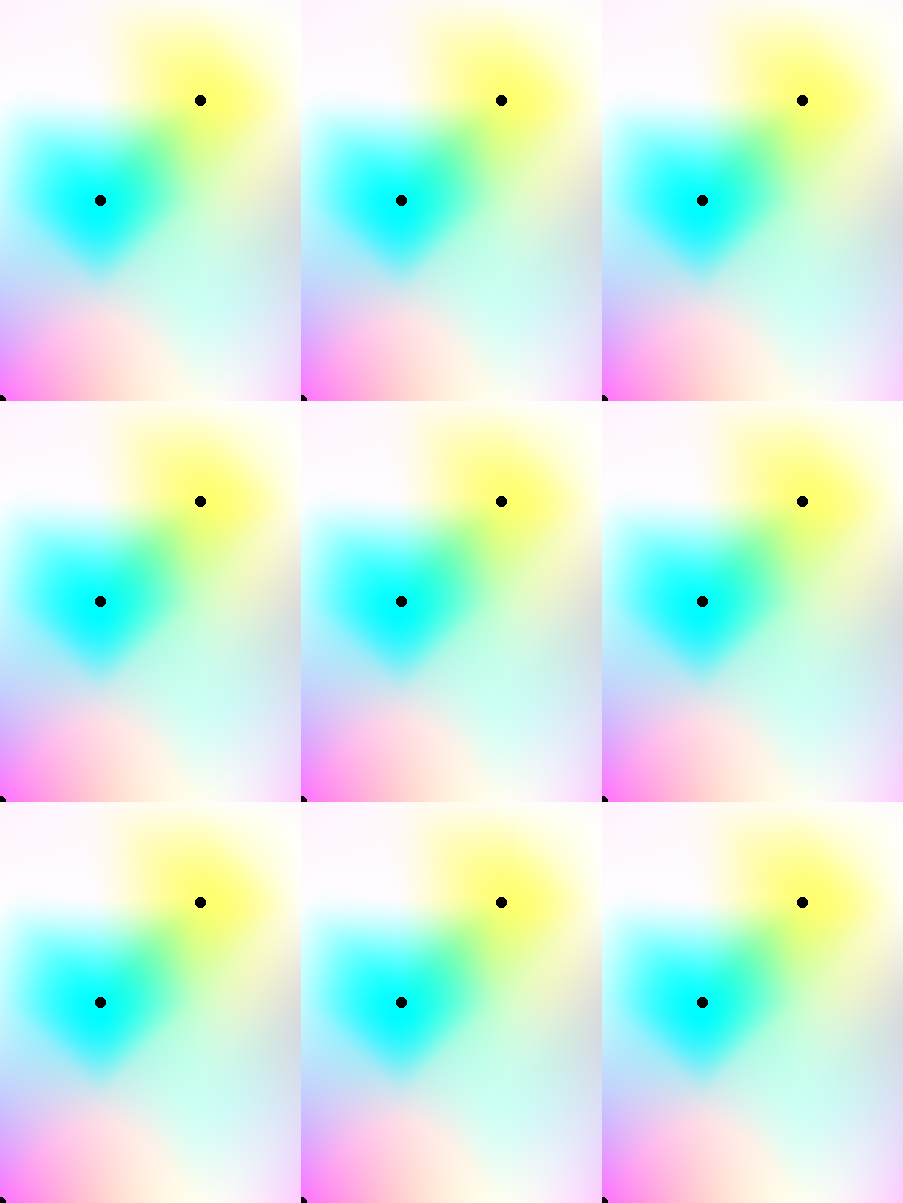

In [210]:
tile_pil(draw_bmus(make_rgb_pil(rgb_img,0),.01,bmu_idxs),3,3)


fruity w/ (0.00,1.00)
(401, 301)


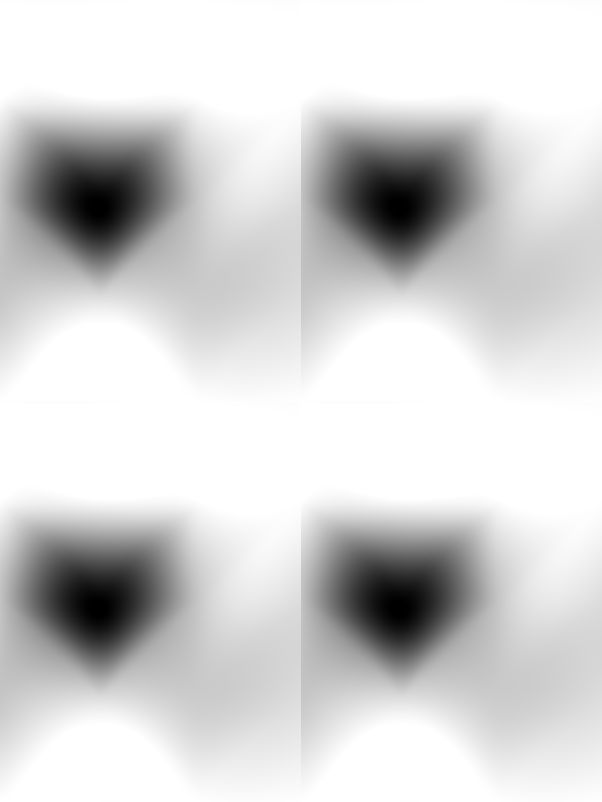

green w/ (0.00,0.56)
(401, 301)


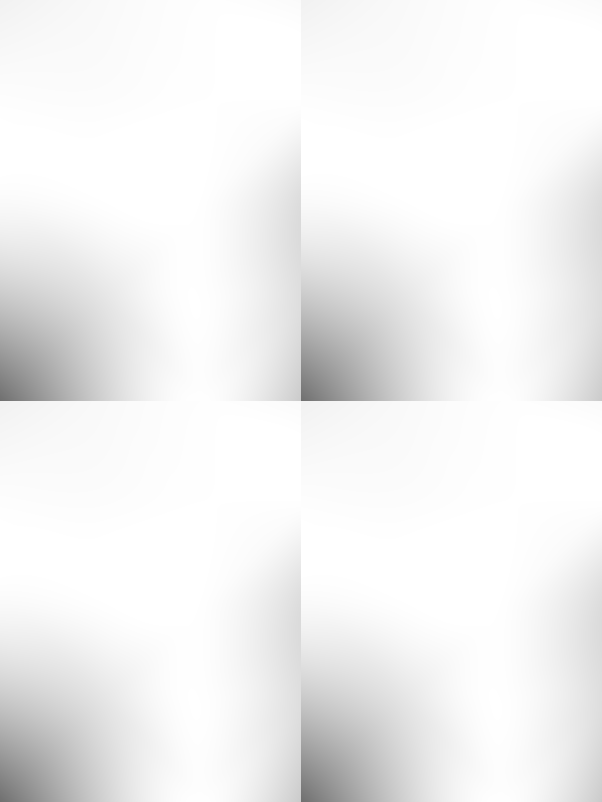

sweet w/ (0.00,0.55)
(401, 301)


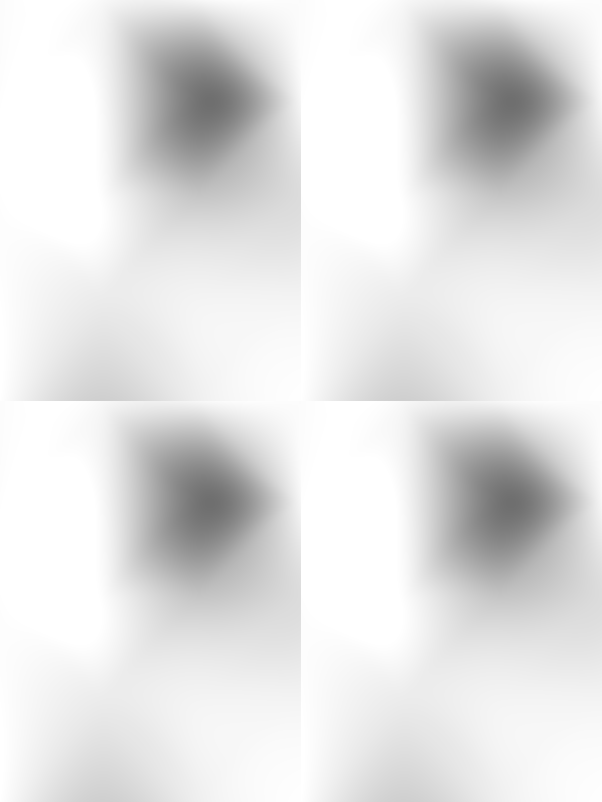

In [214]:
for n,f in all_notes.most_common(3):
    activations = map.get_activations(multi_hot([n]))
    norm = normalize(activations)
    print(f"{n} w/ ({norm.min().numpy():.2f},{norm.max().numpy():.2f})")
    display(tile_pil(make_bw_pil(to_img_array(activations,step=.01,invert=True),0),2,2))
